<a href="https://colab.research.google.com/github/goltsovamaria932/ML_2025_autumn/blob/main/ML_%D0%B4%D0%B7_%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Форма массива: (131, 175, 3)


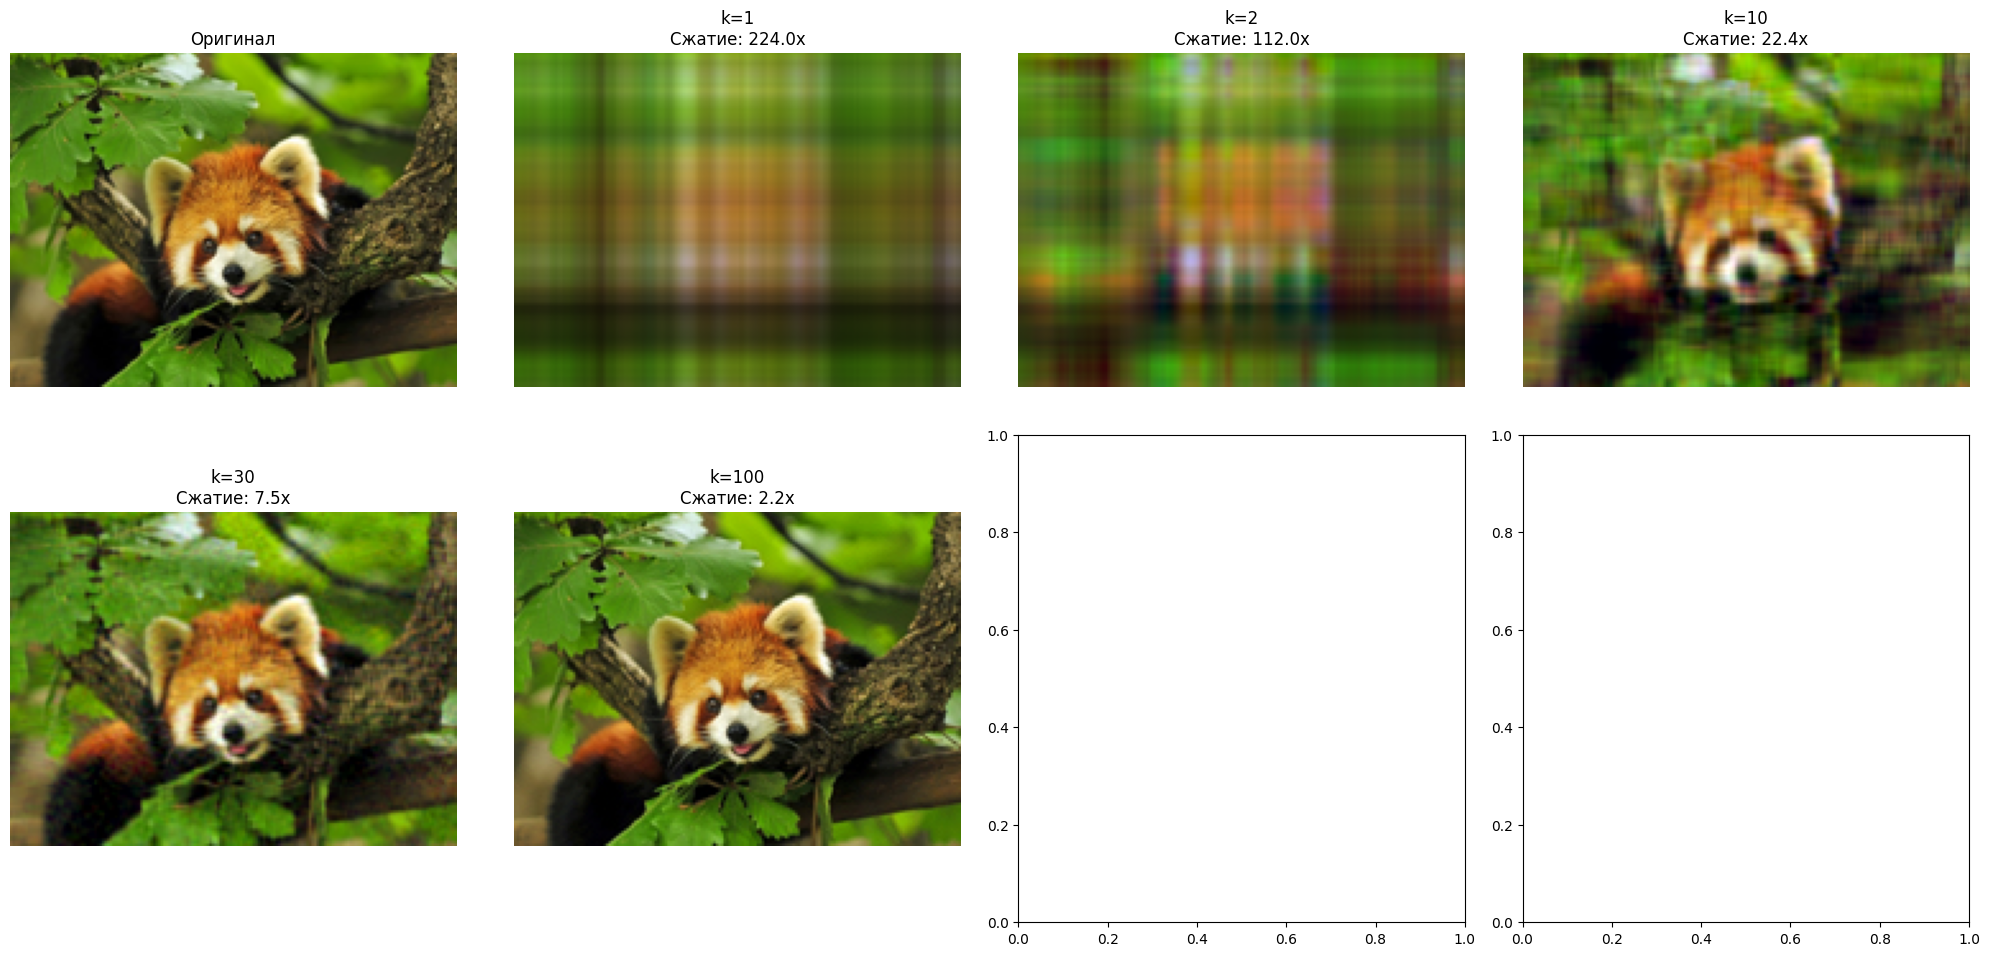

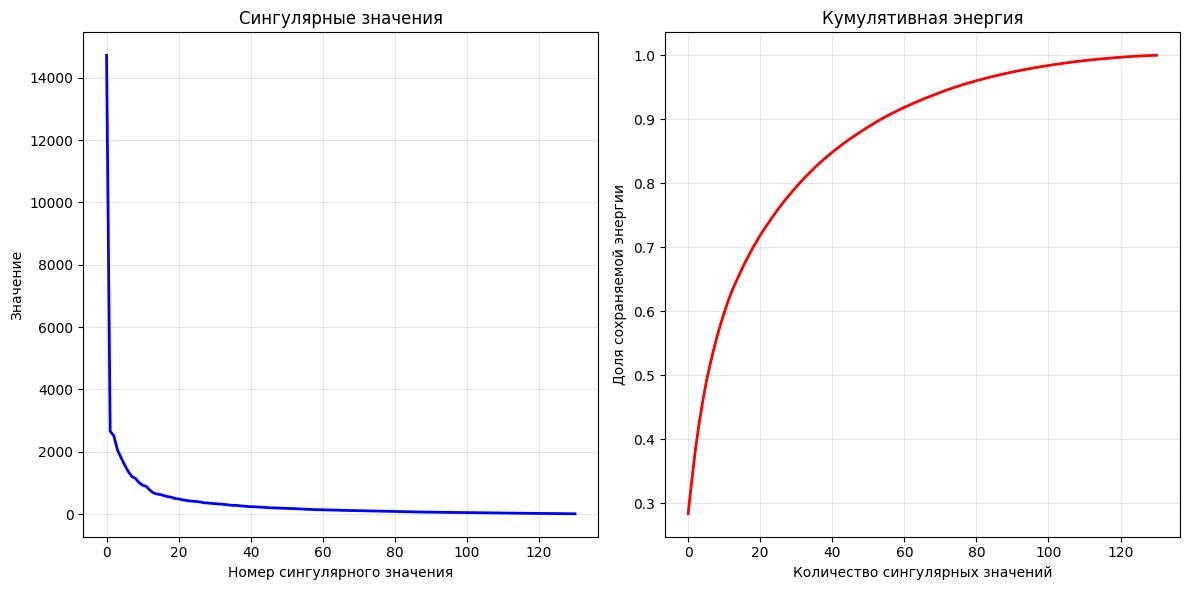

Таблица сравнения размеров:
k	Сжатый размер	Оригинальный размер	Коэф. сжатия	Качество
--------------------------------------------------------------------------------
1	3.6 KB		268.7 KB		74.7x		16.5 dB
2	7.2 KB		268.7 KB		37.3x		17.4 dB
10	36.0 KB		268.7 KB		7.5x		23.0 dB
30	107.9 KB		268.7 KB		2.5x		29.6 dB
100	359.8 KB		268.7 KB		0.7x		46.8 dB

Сжатие в grayscale:
k	Сжатый размер	Оригинальный размер	Коэф. сжатия
------------------------------------------------------------
1	1.2 KB		89.6 KB		74.7x
5	6.0 KB		89.6 KB		14.9x
10	12.0 KB		89.6 KB		7.5x
30	36.0 KB		89.6 KB		2.5x
50	60.0 KB		89.6 KB		1.5x


In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os

img = Image.open('panda.jpg')
w, h = img.size
img = img.resize((w//4, h//4))
w, h = img.size

x = np.array(img, dtype=np.float32)
print(f"Форма массива: {x.shape}")

def compress_channel(channel, k):
    U, S, V = np.linalg.svd(channel, full_matrices=False)
    compressed = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    return np.clip(compressed, 0, 255).astype(np.uint8)

def compress_rgb_image(image_array, k):
    if len(image_array.shape) == 3:
        compressed_channels = []
        for i in range(3):
            compressed_channel = compress_channel(image_array[:, :, i], k)
            compressed_channels.append(compressed_channel)
        return np.stack(compressed_channels, axis=2)
    else:
        return compress_channel(image_array, k)

def calculate_size(U, S, V, k):
    m, n = U.shape[0], V.shape[1]
    size_compressed = (m * k + k + n * k) * 4
    size_original = m * n * 3 * 4
    return size_compressed, size_original

k_values = [1, 2, 10, 30, 100]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

axes[0].imshow(x.astype(np.uint8))
axes[0].set_title('Оригинал')
axes[0].axis('off')

for i, k in enumerate(k_values, 1):
    if i >= len(axes):
        break

    compressed_img = compress_rgb_image(x, k)

    U, S, V = np.linalg.svd(x[:, :, 0], full_matrices=False)
    size_compressed, size_original = calculate_size(U, S, V, k)
    compression_ratio = size_original / size_compressed

    axes[i].imshow(compressed_img)
    axes[i].set_title(f'k={k}\nСжатие: {compression_ratio:.1f}x')
    axes[i].axis('off')

    Image.fromarray(compressed_img).save(f'compressed_k_{k}.jpg')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

channel = x[:, :, 0] if len(x.shape) == 3 else x
U, S, V = np.linalg.svd(channel, full_matrices=False)

plt.subplot(1, 2, 1)
plt.plot(S, 'b-', linewidth=2)
plt.xlabel('Номер сингулярного значения')
plt.ylabel('Значение')
plt.title('Сингулярные значения')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumulative_energy = np.cumsum(S) / np.sum(S)
plt.plot(cumulative_energy, 'r-', linewidth=2)
plt.xlabel('Количество сингулярных значений')
plt.ylabel('Доля сохраняемой энергии')
plt.title('Кумулятивная энергия')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Таблица сравнения размеров:")
print("k\tСжатый размер\tОригинальный размер\tКоэф. сжатия\tКачество")
print("-" * 80)

for k in k_values:
    compressed_img = compress_rgb_image(x, k)

    if len(x.shape) == 3:
        m, n, _ = x.shape
        size_compressed = (m * k * 3 + k * 3 + n * k * 3) * 4
        size_original = m * n * 3 * 4
    else:
        m, n = x.shape
        size_compressed = (m * k + k + n * k) * 4
        size_original = m * n * 4

    compression_ratio = size_original / size_compressed

    if len(x.shape) == 3:
        mse = np.mean((x - compressed_img.astype(np.float32)) ** 2)
    else:
        mse = np.mean((x - compressed_img) ** 2)

    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')

    print(f"{k}\t{size_compressed/1024:.1f} KB\t\t{size_original/1024:.1f} KB\t\t{compression_ratio:.1f}x\t\t{psnr:.1f} dB")

print("\n" + "="*50)
print("Сжатие в grayscale:")

if len(x.shape) == 3:
    x_gray = np.mean(x, axis=2).astype(np.float32)
else:
    x_gray = x

U, S, V = np.linalg.svd(x_gray, full_matrices=False)

print("k\tСжатый размер\tОригинальный размер\tКоэф. сжатия")
print("-" * 60)

for k in [1, 5, 10, 30, 50]:
    m, n = x_gray.shape
    size_compressed = (m * k + k + n * k) * 4
    size_original = m * n * 4
    compression_ratio = size_original / size_compressed

    print(f"{k}\t{size_compressed/1024:.1f} KB\t\t{size_original/1024:.1f} KB\t\t{compression_ratio:.1f}x")

Матрица ковариации после поворота:
[[ 0.14391007 -0.13338208]
 [-0.13338208  0.14269553]]


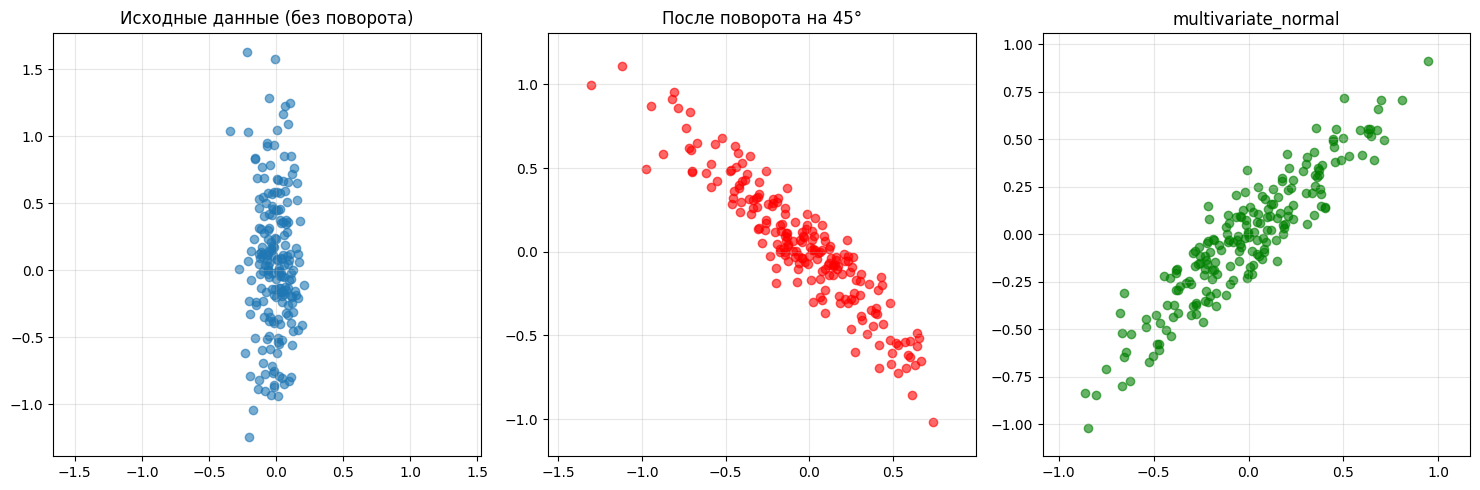

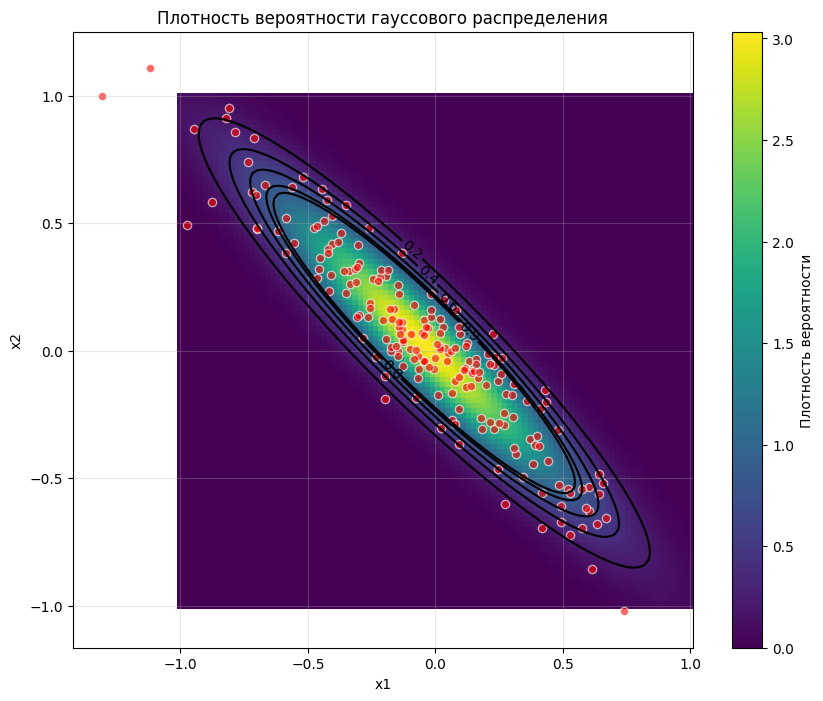

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


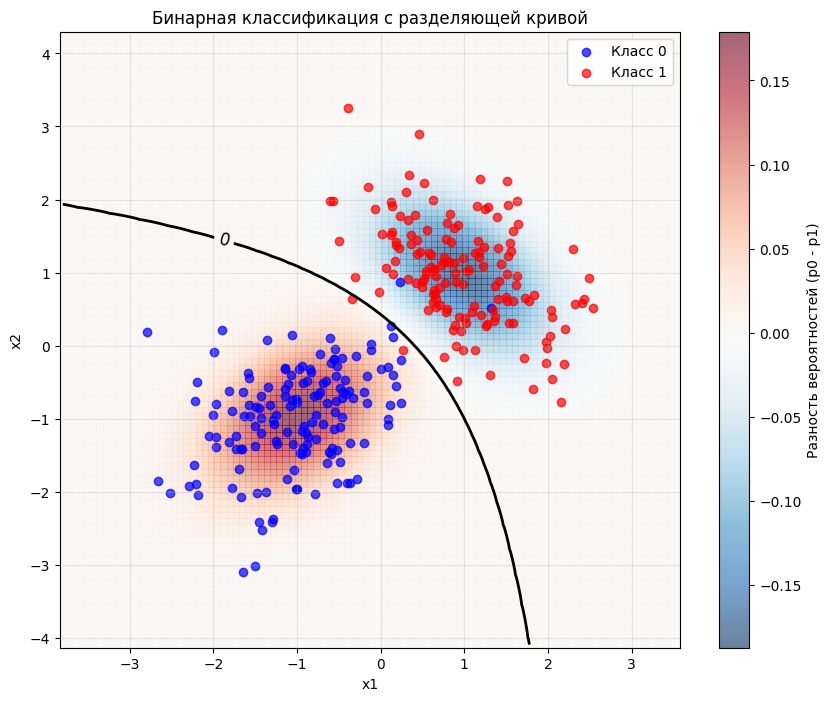

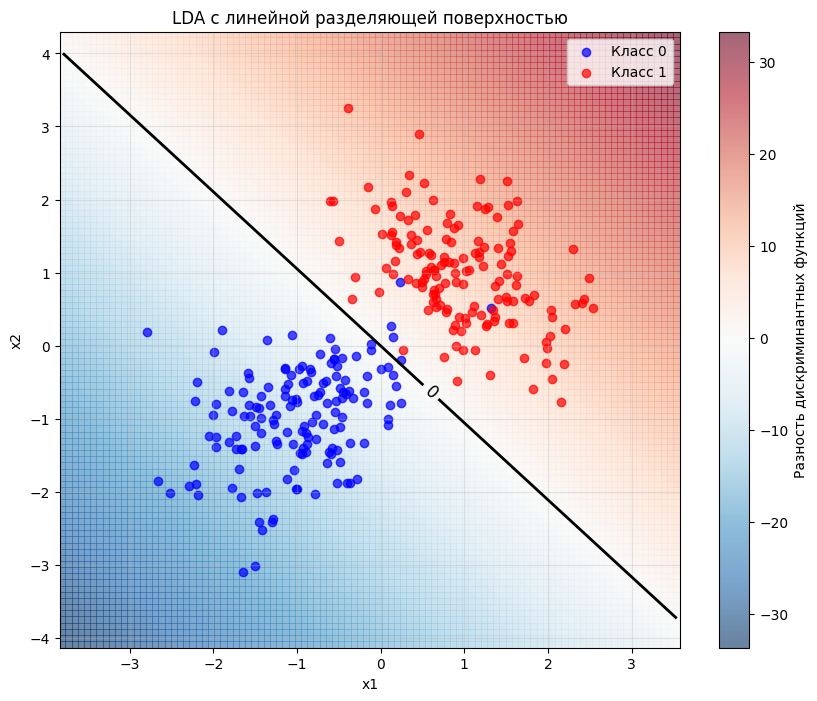

LDA:
  Accuracy: 0.887
  Precision: 0.941
  Recall: 0.830

Naive Bayes:
  Accuracy: 0.883
  Precision: 0.928
  Recall: 0.837



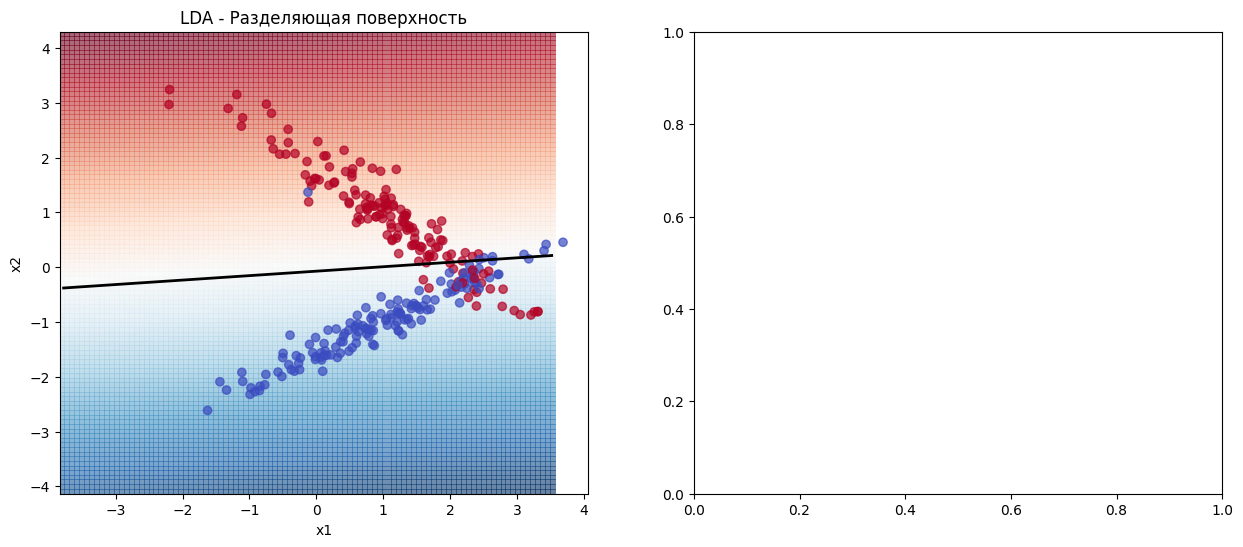

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Многомерное гауссово распределение
M = 200
sigma1 = 0.1
sigma2 = 0.5

# Создание независимых распределений
x1 = np.random.randn(M, 1) * sigma1
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1)

# Матрица поворота на 45 градусов
alpha = np.pi / 4
rotation_matrix = np.array([
    [np.cos(alpha), -np.sin(alpha)],
    [np.sin(alpha), np.cos(alpha)]
])

# Поворот точек
X_rotated = X @ rotation_matrix.T

# Матрица ковариации
cov_matrix = np.cov(X_rotated.T)
print("Матрица ковариации после поворота:")
print(cov_matrix)

# Создание данных с помощью multivariate_normal
mean = [0, 0]
cov_multivariate = np.array([
    [sigma1**2 * np.cos(alpha)**2 + sigma2**2 * np.sin(alpha)**2,
     (sigma2**2 - sigma1**2) * np.sin(alpha) * np.cos(alpha)],
    [(sigma2**2 - sigma1**2) * np.sin(alpha) * np.cos(alpha),
     sigma1**2 * np.sin(alpha)**2 + sigma2**2 * np.cos(alpha)**2]
])

X_multivariate = np.random.multivariate_normal(mean, cov_multivariate, M)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X[:, 0], X[:, 1], alpha=0.6)
axes[0].set_title('Исходные данные (без поворота)')
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

axes[1].scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6, color='red')
axes[1].set_title('После поворота на 45°')
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

axes[2].scatter(X_multivariate[:, 0], X_multivariate[:, 1], alpha=0.6, color='green')
axes[2].set_title('multivariate_normal')
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

plt.tight_layout()
plt.show()

# 2. Плотность вероятности гауссового распределения
mean_rotated = np.mean(X_rotated, axis=0)
cov_rotated = np.cov(X_rotated.T)

# Создание сетки для визуализации
xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100)
XX, YY = np.meshgrid(xx, yy)
pp = np.stack((XX.flatten(), YY.flatten()), axis=1)

# Расчет плотности вероятности
m = multivariate_normal(mean=mean_rotated, cov=cov_rotated)
ZZ = m.pdf(pp).reshape(XX.shape)

# Визуализация
plt.figure(figsize=(10, 8))
IMG = plt.pcolor(XX, YY, ZZ, cmap='viridis')
plt.colorbar(IMG, label='Плотность вероятности')

# Контуры плотности
CS = plt.contour(XX, YY, ZZ, levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)

# Исходные точки
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6, color='red', edgecolors='w')
plt.title('Плотность вероятности гауссового распределения')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# 3. Бинарная классификация
# Создание датасета с двумя классами
np.random.seed(42)
n_samples = 300

# Класс 0
mean0 = [-1, -1]
cov0 = [[0.5, 0.2], [0.2, 0.5]]
X0 = np.random.multivariate_normal(mean0, cov0, n_samples//2)
y0 = np.zeros(n_samples//2)

# Класс 1
mean1 = [1, 1]
cov1 = [[0.5, -0.2], [-0.2, 0.5]]
X1 = np.random.multivariate_normal(mean1, cov1, n_samples//2)
y1 = np.ones(n_samples//2)

# Объединение данных
X_class = np.vstack((X0, X1))
y_class = np.hstack((y0, y1))

# Расчет параметров для каждого класса
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)
C0 = np.cov(X0.T)
C1 = np.cov(X1.T)

# Априорные вероятности
p0 = len(X0) / len(X_class)
p1 = len(X1) / len(X_class)

# Функция для расчета правдоподобия
def calculate_likelihood(x, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(x)

# Создание сетки для визуализации
x_min, x_max = X_class[:, 0].min() - 1, X_class[:, 0].max() + 1
y_min, y_max = X_class[:, 1].min() - 1, X_class[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Расчет разности вероятностей
Z = np.zeros(len(grid_points))
for i, point in enumerate(grid_points):
    likelihood0 = calculate_likelihood(point, mu0, C0) * p0
    likelihood1 = calculate_likelihood(point, mu1, C1) * p1
    Z[i] = likelihood0 - likelihood1

Z = Z.reshape(xx.shape)

# Визуализация
plt.figure(figsize=(10, 8))
plt.pcolor(xx, yy, Z, cmap='RdBu_r', alpha=0.6)
plt.colorbar(label='Разность вероятностей (p0 - p1)')

# Разделяющая кривая (где p0 = p1)
CS = plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
plt.clabel(CS, inline=1, fontsize=12)

# Точки данных
plt.scatter(X0[:, 0], X0[:, 1], c='blue', alpha=0.7, label='Класс 0')
plt.scatter(X1[:, 0], X1[:, 1], c='red', alpha=0.7, label='Класс 1')

plt.title('Бинарная классификация с разделяющей кривой')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. LDA (Linear Discriminant Analysis)
class myLDA(BaseEstimator):
    def __init__(self):
        self.mu0 = None
        self.mu1 = None
        self.shared_cov = None
        self.p0 = None
        self.p1 = None

    def fit(self, X, y):
        # Разделение данных по классам
        X0 = X[y == 0]
        X1 = X[y == 1]

        # Средние значения
        self.mu0 = np.mean(X0, axis=0)
        self.mu1 = np.mean(X1, axis=0)

        # Общая матрица ковариации
        cov0 = np.cov(X0.T) if len(X0) > 1 else np.zeros((X.shape[1], X.shape[1]))
        cov1 = np.cov(X1.T) if len(X1) > 1 else np.zeros((X.shape[1], X.shape[1]))

        n0, n1 = len(X0), len(X1)
        self.shared_cov = (n0 * cov0 + n1 * cov1) / (n0 + n1)

        # Априорные вероятности
        self.p0 = n0 / len(X)
        self.p1 = n1 / len(X)

        return self

    def predict(self, X):
        # Вычисление дискриминантных функций
        inv_cov = np.linalg.inv(self.shared_cov)

        # Линейные коэффициенты
        w0 = inv_cov @ self.mu0
        w1 = inv_cov @ self.mu1

        # Константы
        b0 = -0.5 * self.mu0.T @ inv_cov @ self.mu0 + np.log(self.p0)
        b1 = -0.5 * self.mu1.T @ inv_cov @ self.mu1 + np.log(self.p1)

        # Предсказания
        scores0 = X @ w0 + b0
        scores1 = X @ w1 + b1

        return (scores1 > scores0).astype(int)

# Тестирование LDA
lda = myLDA()
lda.fit(X_class, y_class)
y_pred_lda = lda.predict(X_class)

# Визуализация LDA
plt.figure(figsize=(10, 8))

# Расчет разделяющей поверхности для LDA
Z_lda = np.zeros(len(grid_points))
for i, point in enumerate(grid_points):
    scores0 = point @ (np.linalg.inv(lda.shared_cov) @ lda.mu0) - 0.5 * lda.mu0.T @ np.linalg.inv(lda.shared_cov) @ lda.mu0 + np.log(lda.p0)
    scores1 = point @ (np.linalg.inv(lda.shared_cov) @ lda.mu1) - 0.5 * lda.mu1.T @ np.linalg.inv(lda.shared_cov) @ lda.mu1 + np.log(lda.p1)
    Z_lda[i] = scores1 - scores0

Z_lda = Z_lda.reshape(xx.shape)

plt.pcolor(xx, yy, Z_lda, cmap='RdBu_r', alpha=0.6)
plt.colorbar(label='Разность дискриминантных функций')

# Разделяющая линия
CS = plt.contour(xx, yy, Z_lda, levels=[0], colors='black', linewidths=2)
plt.clabel(CS, inline=1, fontsize=12)

plt.scatter(X0[:, 0], X0[:, 1], c='blue', alpha=0.7, label='Класс 0')
plt.scatter(X1[:, 0], X1[:, 1], c='red', alpha=0.7, label='Класс 1')
plt.title('LDA с линейной разделяющей поверхностью')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Naive Bayes Classifier
class myNB(BaseEstimator):
    def __init__(self):
        self.mu0 = None
        self.mu1 = None
        self.sigma0 = None
        self.sigma1 = None
        self.p0 = None
        self.p1 = None

    def fit(self, X, y):
        X0 = X[y == 0]
        X1 = X[y == 1]

        # Средние и стандартные отклонения для каждого признака
        self.mu0 = np.mean(X0, axis=0)
        self.mu1 = np.mean(X1, axis=0)
        self.sigma0 = np.std(X0, axis=0)
        self.sigma1 = np.std(X1, axis=0)

        # Априорные вероятности
        self.p0 = len(X0) / len(X)
        self.p1 = len(X1) / len(X)

        return self

    def predict(self, X):
        # Расчет логарифма правдоподобия для каждого класса
        log_likelihood0 = np.sum(-0.5 * ((X - self.mu0) / self.sigma0) ** 2 - np.log(self.sigma0 * np.sqrt(2 * np.pi)), axis=1)
        log_likelihood1 = np.sum(-0.5 * ((X - self.mu1) / self.sigma1) ** 2 - np.log(self.sigma1 * np.sqrt(2 * np.pi)), axis=1)

        # Добавление априорных вероятностей
        scores0 = log_likelihood0 + np.log(self.p0)
        scores1 = log_likelihood1 + np.log(self.p1)

        return (scores1 > scores0).astype(int)

# Тестирование Naive Bayes
nb = myNB()
nb.fit(X_class, y_class)
y_pred_nb = nb.predict(X_class)

# 6. Сравнение алгоритмов LDA и NB
# Создание более сложного датасета
X_complex, y_complex = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, random_state=42
)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_complex, y_complex, test_size=0.3, random_state=42
)

# Обучение и предсказание
lda_complex = myLDA()
lda_complex.fit(X_train, y_train)
y_pred_lda_test = lda_complex.predict(X_test)

nb_complex = myNB()
nb_complex.fit(X_train, y_train)
y_pred_nb_test = nb_complex.predict(X_test)

# Метрики
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print()

print_metrics(y_test, y_pred_lda_test, "LDA")
print_metrics(y_test, y_pred_nb_test, "Naive Bayes")

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LDA
Z_lda_complex = np.zeros(len(grid_points))
for i, point in enumerate(grid_points):
    scores0 = point @ (np.linalg.inv(lda_complex.shared_cov) @ lda_complex.mu0) - 0.5 * lda_complex.mu0.T @ np.linalg.inv(lda_complex.shared_cov) @ lda_complex.mu0 + np.log(lda_complex.p0)
    scores1 = point @ (np.linalg.inv(lda_complex.shared_cov) @ lda_complex.mu1) - 0.5 * lda_complex.mu1.T @ np.linalg.inv(lda_complex.shared_cov) @ lda_complex.mu1 + np.log(lda_complex.p1)
    Z_lda_complex[i] = scores1 - scores0

Z_lda_complex = Z_lda_complex.reshape(xx.shape)

axes[0].pcolor(xx, yy, Z_lda_complex, cmap='RdBu_r', alpha=0.6)
axes[0].contour(xx, yy, Z_lda_complex, levels=[0], colors='black', linewidths=2)
axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
axes[0].set_title('LDA - Разделяющая поверхность')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# Naive Bayes
Z_nb_complex = np.zeros(len(grid_points))
for i, point in enumerate(grid_points):
    log_likelihood0 = np.sum(-0.5 * ((point - nb_complex.mu0) / nb_complex.sigma0) ** 2 - np.log(nb_complex.sigma0 * np.sqrt(2 * np.pi)))
    log_likelihood1 = np.sum